# 중성자별 찾는 문제!!

- 중성자별 찾기 문제에서는 중성자를 놓치는 경우(즉, False Negative)가 더 치명적이기 때문에 Recall을 높이는 것이 더 중요하다.
- recall율을 끌어올리기로 결정!!

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

# 업샘플링에 사용되는 라이브러리
from imblearn.over_sampling import ADASYN

path = '../../../../data/star.csv'
bc_data = pd.read_csv(path)

In [7]:
# column명이 너무 길어서 짧게줄임

bc_data.columns = ['Mean_i', 'SD_i', 'EK_i', 'S_i', 'Mean_curve','SD_curve', 'EK_curve', 'S_curve', 'Class']

In [8]:
bc_data.head()

,Mean_i,SD_i,EK_i,S_i,Mean_curve,SD_curve,EK_curve,S_curve,Class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


#### ML Model Predict
• Base모델의 성능

– Epoch : 10 , lr : 0.001

– Train Loss : 1.014

– Test Accuracy = 0.976

– Test Precision = 0.926

– Test Recall = 0.789

– Test F1 = 0.852

#### 모델링 순서
- 크게 두가지 scaler 중 택 1
- 오버샘플링 할지 안할지 택 1
- 대표적인 분류모델로 Logistic Regression, RandomForest, Xgboost 모델 사용하기로 -> 추후 SVM도 도전

#### 참고자료(오버샘플링)
https://givitallugot.github.io/articles/2021-07/Python-imbalanced-sampling-copy<br>

SMOTE (Synthetic Minority Over-sampling Technique):

소수 클래스 샘플들을 임의의 점들로 연결하여 선분을 만들고, 그 선분 상에 새로운 합성 샘플을 생성하는 방식입니다.
SMOTE는 소수 클래스 샘플 간의 거리를 보고 샘플을 생성하기 때문에 주로 잡음이 적고 자연스러운 합성 샘플을 생성합니다.
하지만 클래스 간의 결정 경계 부근에 있는 소수 클래스 샘플은 과도하게 복제될 수 있으며, 이는 모델의 성능에 영향을 미칠 수 있습니다.

ADASYN (Adaptive Synthetic Sampling):

SMOTE와 비슷하게 소수 클래스 샘플들에 대해서 새로운 샘플을 합성하지만, ADASYN은 더욱 더 적은 수의 합성 샘플을 생성하면서 샘플링의 어려움을 완화하는 방식입니다.
ADASYN은 소수 클래스 샘플들 중에서 결정 경계 부근에 있는 샘플들에 가중치를 부여하여 합성 샘플을 생성합니다. 이렇게 함으로써 결정 경계 부근의 소수 클래스 샘플들이 더 많은 합성 샘플을 받게 됩니다.
따라서 ADASYN은 결정 경계 부근의 소수 클래스 샘플들을 더 적게 복제하고, 더 멀리 있는 소수 클래스 샘플들은 더 많이 복제하여 더 다양한 합성 샘플을 생성합니다.

- 다양성을 위해 ADASYN으로!!!

In [22]:
def split_dataset(df, test_ratio = 0.2, select=1, upsampling=None):
    # 미리 전역변수로 설정해두기
    global x_df, y_df, scaler
    
    # 학습 데이터 분리
    x_df = df.drop('Class', axis=1)
    y_df = df['Class']
    
    x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=test_ratio, random_state=42, stratify=y_df)
    
    # 대표적인 표준화 두가지 중 택1
    if select == 1:
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()
    
    # 타겟이 불균형하므로 오버샘플링을 해보기(매개변수를 지정안해주면 None이 실행되므로 if문에 안들어감 2가지 방법 실험용)
    # 스모트(SMOTE) 대신에 아다신(ADASYN) 사용된 이유는 좀 더 랜덤하게 업스케일링이 되게 하게 위해 사용
    if upsampling:
        adasyn = ADASYN(random_state=42)
        x_train, y_train = adasyn.fit_resample(x_train, y_train)
    
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    x_train = pd.DataFrame(x_train, columns=x_df.columns)
    x_test = pd.DataFrame(x_test, columns=x_df.columns)

    return x_train, x_test, y_train, y_test

#### BaseModel에서 훈련, 테스트 데이터만 보여주었기에 교차검증을 통해 검증성능 확인

In [23]:
def get_metrics(model, x_train, y_train):

    # 교차 검증 수행 및 평가 지표 계산
    scoring = {
    'accuracy': 'accuracy',
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1_score': make_scorer(f1_score)
    }
    # 훈련 평가지표 출력
    model.fit(x_train, y_train)
    y_pred = model.predict(x_train)
    print("훈련 정확도: ", model.score(x_train, y_train))
    print("훈련 recall: ", recall_score(y_train, y_pred))
    print("훈련 Precision: ", precision_score(y_train, y_pred))
    print("훈련 F1-score: ", f1_score(y_train, y_pred))

    # 교차검증 5개로 분할
    cv_results = cross_validate(model, x_train, y_train, cv=5, scoring=scoring)
    
    # 교차 검증 결과를 데이터프레임으로 변환
    cv_results_df = pd.DataFrame(cv_results)
    
    # 평균값을 추가한 새로운 행을 생성하여 데이터프레임에 추가
    mean_scores = cv_results_df.mean().to_frame().T
    mean_scores.rename(index={0: 'mean'}, inplace=True)
    cv_results_df = pd.concat([cv_results_df, mean_scores], axis=0)

    return cv_results_df

#### StandardScaler 사용 upsampling No -> x_train1

In [25]:
# 함수 호출
x_train1, x_test1, y_train1, y_test1 = split_dataset(df=bc_data, test_ratio=0.2, select=1)

In [27]:
print('훈련 데이터 shape:', x_train1.shape, y_train1.shape)
print('테스트 데이터 shape:', x_test1.shape, y_test1.shape)

훈련 데이터 shape: (14318, 8) (14318,)
테스트 데이터 shape: (3580, 8) (3580,)


In [28]:
print(y_train1.value_counts(normalize=True))
y_test1.value_counts(normalize=True)

0    0.908437
1    0.091563
Name: Class, dtype: float64


0    0.90838
1    0.09162
Name: Class, dtype: float64

#### StandardScaler 사용 upsampling Yes -> x_train2

In [10]:
# 함수 호출
x_train2, x_test2, y_train2, y_test2 = split_dataset(df=bc_data, test_ratio=0.2, select=1, upsampling=1)

In [11]:
print('훈련 데이터 shape:', x_train2.shape, y_train2.shape)
print('테스트 데이터 shape:', x_test2.shape, y_test2.shape)

훈련 데이터 shape: (26047, 8) (26047,)
테스트 데이터 shape: (3580, 8) (3580,)


In [12]:
print(y_train2.value_counts(normalize=True))
y_test2.value_counts(normalize=True)

1    0.500633
0    0.499367
Name: Class, dtype: float64


0    0.90838
1    0.09162
Name: Class, dtype: float64

#### MinMaxScaler 사용 upsampling No -> x_train3

In [13]:
# 함수 호출
x_train3, x_test3, y_train3, y_test3 = split_dataset(df=bc_data, test_ratio=0.2, select=2)

In [14]:
print('훈련 데이터 shape:', x_train3.shape, y_train3.shape)
print('테스트 데이터 shape:', x_test3.shape, y_test3.shape)

훈련 데이터 shape: (14318, 8) (14318,)
테스트 데이터 shape: (3580, 8) (3580,)


In [15]:
print(y_train3.value_counts(normalize=True))
y_test3.value_counts(normalize=True)

0    0.908437
1    0.091563
Name: Class, dtype: float64


0    0.90838
1    0.09162
Name: Class, dtype: float64

#### MinMaxScaler 사용 upsampling Yes -> x_train4

In [16]:
# 함수 호출
x_train4, x_test4, y_train4, y_test4 = split_dataset(df=bc_data, test_ratio=0.2, select=2, upsampling=1)

In [17]:
print('훈련 데이터 shape:', x_train4.shape, y_train4.shape)
print('테스트 데이터 shape:', x_test4.shape, y_test4.shape)

훈련 데이터 shape: (26047, 8) (26047,)
테스트 데이터 shape: (3580, 8) (3580,)


In [18]:
print(y_train4.value_counts(normalize=True))
y_test4.value_counts(normalize=True)

1    0.500633
0    0.499367
Name: Class, dtype: float64


0    0.90838
1    0.09162
Name: Class, dtype: float64

## Logistic Model Start!!!
- 처음은 파라미터 없이 그다음부터 파라미터 추가

#### Standard 오버샘플링 사용 안한 파일

In [29]:
# x_train1

lg_model = LogisticRegression(random_state=42)
get_metrics(model=lg_model, x_train=x_train1, y_train=y_train1)

훈련 정확도:  0.9785584578851795
훈련 recall:  0.8184591914569032
훈련 Precision:  0.9395796847635727
훈련 F1-score:  0.8748471259682024


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,0.015464,0.005054,0.980796,0.836502,0.948276,0.888889
1,0.016051,0.004601,0.978352,0.824427,0.931034,0.874494
2,0.016591,0.004271,0.978003,0.805344,0.946188,0.870103
3,0.016130,0.004630,0.976249,0.786260,0.944954,0.858333
4,0.014628,0.004281,0.977995,0.828244,0.923404,0.873239
mean,0.015773,0.004567,0.978279,0.816155,0.938771,0.873012


#### Standard 오버샘플링 사용된 파일

In [129]:
# x_train2

get_metrics(model=lg_model, x_train=x_train2, y_train=y_train2)

훈련 정확도:  0.8438975697777096
훈련 recall:  0.8019171779141104
훈련 Precision:  0.8757956448911223
훈련 F1-score:  0.8372297838270616


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,0.030360,0.006348,0.881382,0.896089,0.870715,0.883220
1,0.028458,0.005940,0.812476,0.732362,0.872545,0.796331
2,0.031827,0.006086,0.822423,0.751534,0.876173,0.809082
3,0.030998,0.005503,0.854675,0.820936,0.880708,0.849772
4,0.028780,0.005401,0.830294,0.777224,0.869957,0.820980
mean,0.030085,0.005856,0.840250,0.795629,0.874020,0.831877


#### MinMax사용 오버샘플링 안한 파일

In [130]:
# x_train3

get_metrics(model=lg_model, x_train=x_train3, y_train=y_train3)

훈련 정확도:  0.9739488755412767
훈련 recall:  0.7640364188163885
훈련 Precision:  0.9420018709073901
훈련 F1-score:  0.8437369082530373


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,0.024671,0.004884,0.970670,0.723485,0.945545,0.819742
1,0.016866,0.004817,0.976257,0.787879,0.945455,0.859504
2,0.015231,0.004883,0.973115,0.765152,0.930876,0.839917
3,0.014816,0.004375,0.975899,0.787072,0.940909,0.857143
4,0.017981,0.004460,0.972407,0.741445,0.946602,0.831557
mean,0.017913,0.004684,0.973670,0.761006,0.941877,0.841573


#### MinMax사용 오버샘플링 사용한 파일

In [131]:
# x_train4

get_metrics(model=lg_model, x_train=x_train4, y_train=y_train4)

훈련 정확도:  0.8287910820680376
훈련 recall:  0.7725701114099116
훈련 Precision:  0.8706381504892199
훈련 F1-score:  0.8186777397817946


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,0.054214,0.006099,0.851240,0.832117,0.865362,0.848414
1,0.030155,0.005618,0.783779,0.676527,0.861546,0.757908
2,0.030994,0.005509,0.848549,0.810603,0.877339,0.842652
3,0.028852,0.005309,0.811839,0.740300,0.864126,0.797434
4,0.036386,0.005907,0.830098,0.786784,0.861590,0.822490
mean,0.036120,0.005688,0.825101,0.769266,0.865992,0.813780


- 오버샘플링을 한 파일이 안한것만 못함... logistic은 안하고 진행해보기로 함
- 기본으로도 성능은 전체적으로 평균적이나 조금더 성능을 끌어올려보기로 함
- 머신러닝으로도 충분히 해결될 수 있는 문제로 보여 하이퍼파라미터 조정!
- **4가지 데이터중에 Standard표준화에 오버샘플링 안한 파일이 가장 안정적 이거로 진행해보기로 결정**

## Logistic 하이퍼파라미터 조정(x_train1)
- 일단 타겟이 불균형한 문제도 있기에 x_train1은 오버샘플링을 사용하지 않았기에 balanced 사용하기로 결정
- 문제가 소수인 중성자별을 판단하는게 중요하다고 여겨 recall값을 최대한 끌어올려보기로 함!
- 그리고 업샘플링 안한 데이터이기에 일단 기본으로 class_weight는 balanced를 가져가야 한다고 생각함 
- target 비율 9:1
- logistic 모델의 경우 파라미터가 얼마 없어 수작업으로 조금씩 수정함

#### 공식문서
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [30]:
lg_model = LogisticRegression(class_weight='balanced',
                              C = 1.5,
                              penalty='l2',
                              random_state=42)

In [31]:
get_metrics(model=lg_model, x_train=x_train1, y_train=y_train1)

훈련 정확도:  0.9686408716301159
훈련 recall:  0.9130434782608695
훈련 Precision:  0.7813315926892951
훈련 F1-score:  0.8420682377769961


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,0.019696,0.004962,0.967179,0.931559,0.763240,0.839041
1,0.016351,0.004326,0.971369,0.893130,0.812500,0.850909
2,0.018555,0.004552,0.967179,0.893130,0.780000,0.832740
3,0.017916,0.004439,0.969962,0.916031,0.789474,0.848057
4,0.019508,0.004555,0.967167,0.923664,0.765823,0.837370
mean,0.018405,0.004567,0.968571,0.911503,0.782207,0.841623


#### test셋으로 확인

In [32]:
y_test_pred = lg_model.predict(x_test1)
print("테스트 정확도: ", lg_model.score(x_test1, y_test1))
print("테스트 recall: ", recall_score(y_test1, y_test_pred))
print("테스트 Precision: ", precision_score(y_test1, y_test_pred))
print("테스트 F1-score: ", f1_score(y_test1, y_test_pred))

테스트 정확도:  0.9695530726256983
테스트 recall:  0.9207317073170732
테스트 Precision:  0.7844155844155845
테스트 F1-score:  0.847124824684432


### lg_model confusion matrix 확인

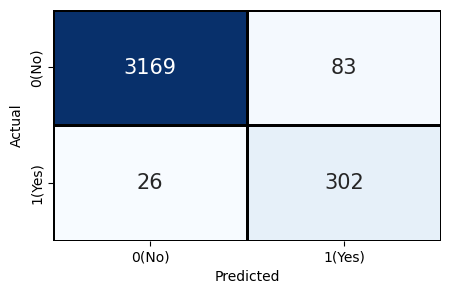

In [33]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize = (5, 3))
sns.heatmap(confusion_matrix(y_test1, y_test_pred), cmap = 'Blues',
            cbar = False, annot = True, annot_kws = {'size' : 15},
            fmt = '.0f', xticklabels = ['0(No)', '1(Yes)'], yticklabels = ['0(No)', '1(Yes)'],
            linecolor = 'k', linewidths = 0.8)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### recall율이 많이 오른것을 확인 일단 저장

In [34]:
base_metrics = {
    'Test Accuracy': 0.98,
    'Test Precision': 0.93,
    'Test Recall': 0.79,
    'Test F1': 0.85
}

lg_test_metrics = {
    'Test Accuracy': lg_model.score(x_test1, y_test1).round(2),
    'Test Precision': precision_score(y_test1, y_test_pred).round(2),
    'Test Recall': recall_score(y_test1, y_test_pred).round(2),
    'Test F1': f1_score(y_test1, y_test_pred).round(2)
}

base_df = pd.DataFrame([base_metrics])
lg_test_df = pd.DataFrame([lg_test_metrics])

base_df['Model'] = 'base'
lg_test_df['Model'] = 'lg_test'

base_df.set_index('Model', inplace=True)
lg_test_df.set_index('Model', inplace=True)

lg_result_df = pd.concat([base_df, lg_test_df])

lg_result_df

,Test Accuracy,Test Precision,Test Recall,Test F1
Model,,,,
base,0.98,0.93,0.79,0.85
lg_test,0.97,0.78,0.92,0.85


In [36]:
import pickle

# 모델 피클링 (저장)
with open('lg_model.pkl', 'wb') as file:
    pickle.dump(lg_model, file)

# scaler 저장
with open('lg_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# # 모델 언피클링 (불러오기)
# with open('model.pkl', 'rb') as file:
#     loaded_model = pickle.load(file)

## RandomForest 시작!!!

In [166]:
# x_train1

rf_model = RandomForestClassifier(random_state=42)
get_metrics(model=rf_model, x_train=x_train1, y_train=y_train1)

훈련 정확도:  0.9999301578432742
훈련 recall:  0.9992412746585736
훈련 Precision:  1.0
훈련 F1-score:  0.9996204933586337


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,1.493037,0.026562,0.977654,0.825758,0.923729,0.872000
1,1.472955,0.026848,0.981494,0.859848,0.934156,0.895464
2,1.528115,0.027096,0.975908,0.814394,0.914894,0.861723
3,1.528467,0.027235,0.983933,0.882129,0.939271,0.909804
4,1.542356,0.027336,0.977297,0.813688,0.930435,0.868154
mean,1.512986,0.027015,0.979257,0.839163,0.928497,0.881429


In [167]:
# x_train2

get_metrics(model=rf_model, x_train=x_train2, y_train=y_train2)

훈련 정확도:  1.0
훈련 recall:  1.0
훈련 Precision:  1.0
훈련 F1-score:  1.0


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,3.043891,0.052222,0.969482,0.971242,0.967902,0.969569
1,2.956297,0.049643,0.934933,0.902224,0.965531,0.932805
2,3.012503,0.050397,0.927817,0.884586,0.968514,0.924649
3,2.978909,0.050779,0.969284,0.966258,0.972222,0.969231
4,2.992874,0.049836,0.929161,0.885353,0.970576,0.926008
mean,2.996895,0.050575,0.946135,0.921933,0.968949,0.944452


In [168]:
# x_train3

get_metrics(model=rf_model, x_train=x_train3, y_train=y_train3)

훈련 정확도:  0.9999301578432742
훈련 recall:  0.9992412746585736
훈련 Precision:  1.0
훈련 F1-score:  0.9996204933586337


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,1.492306,0.026881,0.978003,0.825758,0.927660,0.873747
1,1.471965,0.027209,0.981494,0.859848,0.934156,0.895464
2,1.521879,0.027089,0.975908,0.814394,0.914894,0.861723
3,1.515591,0.027131,0.983933,0.882129,0.939271,0.909804
4,1.538992,0.027520,0.977646,0.817490,0.930736,0.870445
mean,1.508147,0.027166,0.979397,0.839924,0.929343,0.882237


In [169]:
# x_train4

get_metrics(model=rf_model, x_train=x_train4, y_train=y_train4)

훈련 정확도:  1.0
훈련 recall:  1.0
훈련 Precision:  1.0
훈련 F1-score:  1.0


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,2.970759,0.051120,0.939458,0.914330,0.962783,0.937931
1,3.062492,0.050195,0.932539,0.898194,0.964521,0.930177
2,2.926706,0.050182,0.949452,0.933538,0.964286,0.948663
3,2.980451,0.050194,0.945993,0.922397,0.968145,0.944718
4,2.945428,0.050360,0.958678,0.951978,0.964953,0.958422
mean,2.977167,0.050410,0.945224,0.924088,0.964938,0.943982


#### RandomForest모델에서는 Standard를 사용하고 오버샘플링을 사용한 데이터가 가장 기본으로 만들었을때 성능이 좋았음
- x_train2 채택!
- 어느정도 성능이 높게 나왔지만 살짝 과적합 의심
- 조금 더 안정화를 시켜야한다고 생각하고 파라미터 조정

## RandomForest 하이퍼파라미터 조정(x_train2)
- 일단 오버샘플링을 해놓은 데이터이기에 class_weight는 조정해보기로(할수도있고 안할수도?)
- 최적의 조합을 찾기위해 어느정도 파라미터가 많기에 그리드서치 or 랜덤서치 기법 활용해보기로

#### 참고자료
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier

In [143]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint

##### Random Search 활용
- 과적합인지 아닌지 조금 불확실해서 조합을 잘 생각해봐야할듯

In [165]:
rf_model = RandomForestClassifier(random_state=42,
                                  class_weight='balanced')
param_dist = {
    'n_estimators': randint(100, 1000), # 이 값을 늘리면 더 많은 트리를 사용하여 예측을 평균화하므로 일반화 성능을 향상시킬 수 있다.
    'max_depth': randint(1, 10), # 작은 값으로 설정하면 트리의 복잡성이 줄어들어 과적합을 방지
    'min_samples_split': randint(2, 20), # 큰 값으로 설정하면 과적합을 방지하는 데 도움
    'min_samples_leaf': randint(2, 20), # 큰 값으로 설정하면 과적합을 방지하는 데 도움
    'max_features' : randint(1, 8), # 특성 수를 제한하여 과적합을 줄일 수 있다.
    'bootstrap' : [True, False] # True로 설정하면 bagging이 활성화되어 일반화 성능을 향상시킬 수 있다.
}

# 랜덤 서치 수행
random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='recall', random_state=42
)

# 학습 데이터에 랜덤 서치 수행
random_search.fit(x_train2, y_train2)

# 최적의 하이퍼파라미터와 평가 지표 출력
print("최적의 하이퍼파라미터: ", random_search.best_params_)
print("최고 recall: ", random_search.best_score_)

최적의 하이퍼파라미터:  {'bootstrap': False, 'max_depth': 9, 'min_samples_leaf': 15, 'min_samples_split': 19, 'n_estimators': 876}
최고 recall:  0.8702453987730061


- 랜덤서치1<br>
최적의 하이퍼파라미터:  {'max_depth': 7, 'max_features': 6, 'min_samples_leaf': 9, 'min_samples_split': 8, 'n_estimators': 423}
최고 recall:  0.8520705521472394

- 랜덤서치2<br>
최적의 하이퍼파라미터:  {'bootstrap': False, 'max_depth': 1, 'max_features': 4, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 796}
최고 recall:  0.8881901840490798

- 랜덤서치3<br>
최적의 하이퍼파라미터:  {'bootstrap': True, 'max_depth': 8, 'max_features': 12, 'min_samples_leaf': 11, 'min_samples_split': 5, 'n_estimators': 863}
최고 recall:  0.8757668711656443

- 랜덤서치4<br>
최적의 하이퍼파라미터:  {'bootstrap': True, 'max_depth': 8, 'max_features': 11, 'min_samples_leaf': 12, 'min_samples_split': 13, 'n_estimators': 932}
최고 recall:  0.8756134969325154

- 랜덤서치5<br>
최적의 하이퍼파라미터:  {'bootstrap': False, 'max_depth': 9, 'max_features': 3, 'min_samples_leaf': 15, 'min_samples_split': 14, 'n_estimators': 919}
최고 recall:  0.8782208588957054

- 랜덤서치6<br>
최적의 하이퍼파라미터:  {'bootstrap': False, 'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 82}
최고 recall:  0.8759202453987729

- 랜덤서치7<br>
최적의 하이퍼파라미터:  {'bootstrap': False, 'max_depth': 8, 'max_features': 6, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 113}
최고 recall:  0.8733128834355828

- 랜덤서치8<br>
최적의 하이퍼파라미터:  {'bootstrap': True, 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 158}
최고 recall:  0.8781441717791412

- 랜덤서치9<br>
최적의 하이퍼파라미터:  {'bootstrap': True, 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 158}
최고 recall:  0.8781441717791412

- 랜덤서치10<br>
최적의 하이퍼파라미터:  {'bootstrap': False, 'max_depth': 9, 'min_samples_leaf': 15, 'min_samples_split': 19, 'n_estimators': 876}
최고 recall:  0.8702453987730061

#### 테스트용

In [145]:
rf_model = RandomForestClassifier(class_weight='balanced',
                                  max_depth=9,
                                  min_samples_leaf=3,
                                  min_samples_split=6,
                                  n_estimators=456,
                                  random_state=42)

In [171]:
get_metrics(model=rf_model, x_train=x_train2, y_train=y_train2)

훈련 정확도:  1.0
훈련 recall:  1.0
훈련 Precision:  1.0
훈련 F1-score:  1.0


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,3.045087,0.052375,0.969482,0.971242,0.967902,0.969569
1,2.964457,0.050176,0.934933,0.902224,0.965531,0.932805
2,3.036021,0.050621,0.927817,0.884586,0.968514,0.924649
3,2.995503,0.051119,0.969284,0.966258,0.972222,0.969231
4,2.992252,0.049468,0.929161,0.885353,0.970576,0.926008
mean,3.006664,0.050752,0.946135,0.921933,0.968949,0.944452


In [172]:
y_test_pred = rf_model.predict(x_test2)
print("테스트 정확도: ", rf_model.score(x_test2, y_test2))
print("테스트 recall: ", recall_score(y_test2, y_test_pred))
print("테스트 Precision: ", precision_score(y_test2, y_test_pred))
print("테스트 F1-score: ", f1_score(y_test2, y_test_pred))

테스트 정확도:  0.9639664804469273
테스트 recall:  0.8963414634146342
테스트 Precision:  0.7557840616966581
테스트 F1-score:  0.8200836820083682


#### Grid Search 활용

In [173]:
# 모델 생성
model = RandomForestClassifier()

# 하이퍼파라미터 후보들을 딕셔너리 형태로 정의
param_grid = {
    'n_estimators': [200, 300, 400, 500, 600, 700],  # 결정 트리 개수 후보
    'max_depth': [None, 1, 5, 10, 15, 20],  # 최대 깊이 후보
    'min_samples_split': [2, 5, 10, 15, 20],  # 노드를 분할하기 위한 최소 샘플 수 후보
    'min_samples_leaf': [1, 2, 4, 6, 8, 10]  # 리프 노드에 필요한 최소 샘플 수 후보
}

# Recall을 사용하여 그리드 서치 수행
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='recall')

# 학습 데이터에 그리드 서치 수행
grid_search.fit(x_train2, y_train2)

# 최적의 파라미터와 성능 확인
print("최적의 하이퍼파라미터:", grid_search.best_params_)
print("최고 Recall:", grid_search.best_score_)

최적의 하이퍼파라미터: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
최고 Recall: 0.9259969325153374


#### Grid 1829분 동안 돌린결과...

최적의 하이퍼파라미터: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
최고 Recall: 0.9259969325153374

In [22]:
rf_model = RandomForestClassifier(
                                  max_depth=15,
                                  min_samples_leaf=1,
                                  min_samples_split=2,
                                  n_estimators=200,
                                  random_state=42)

### class_weight 하기전 성능

In [20]:
get_metrics(model=rf_model, x_train=x_train2, y_train=y_train2)

훈련 정확도:  0.9928974546012976
훈련 recall:  0.9997699386503067
훈련 Precision:  0.9862319388758605
훈련 F1-score:  0.9929547964507407


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,5.589598,0.096383,0.966219,0.972776,0.960257,0.966476
1,5.580424,0.093824,0.935509,0.906058,0.962918,0.933623
2,5.659273,0.093072,0.927049,0.890721,0.960711,0.924393
3,5.606857,0.094006,0.966980,0.966258,0.967742,0.966999
4,5.610049,0.093220,0.926473,0.885736,0.964509,0.923446
mean,5.609240,0.094101,0.944446,0.924310,0.963228,0.942988


### class_weight balanced 설정 후

In [257]:
rf_model = RandomForestClassifier(class_weight='balanced',
                                  max_depth=15,
                                  min_samples_leaf=1,
                                  min_samples_split=2,
                                  n_estimators=200)

In [258]:
get_metrics(model=rf_model, x_train=x_train2, y_train=y_train2)

훈련 정확도:  0.9930510231504588
훈련 recall:  0.9999233128834356
훈련 Precision:  0.986383236250851
훈련 F1-score:  0.9931071251761301


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,5.661268,0.092438,0.967754,0.974310,0.961771,0.968000
1,5.681469,0.090371,0.935125,0.908742,0.959514,0.933438
2,5.697196,0.090614,0.928009,0.892638,0.960792,0.925462
3,5.604351,0.091473,0.968708,0.969709,0.967853,0.968780
4,5.646397,0.089529,0.928009,0.887270,0.966180,0.925045
mean,5.658136,0.090885,0.945521,0.926534,0.963222,0.944145


In [259]:
y_test_pred = rf_model.predict(x_test2)
print("테스트 정확도: ", rf_model.score(x_test2, y_test2))
print("테스트 recall: ", recall_score(y_test2, y_test_pred))
print("테스트 Precision: ", precision_score(y_test2, y_test_pred))
print("테스트 F1-score: ", f1_score(y_test2, y_test_pred))

테스트 정확도:  0.9578212290502793
테스트 recall:  0.899390243902439
테스트 Precision:  0.7142857142857143
테스트 F1-score:  0.7962213225371121


### rf_model confusion matrix 확인

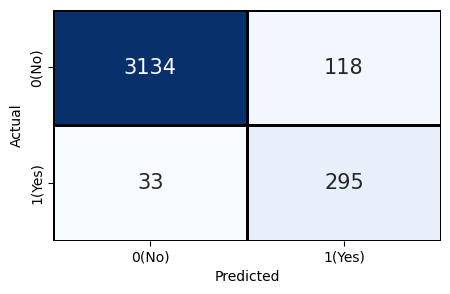

In [260]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize = (5, 3))
sns.heatmap(confusion_matrix(y_test2, y_test_pred), cmap = 'Blues',
            cbar = False, annot = True, annot_kws = {'size' : 15},
            fmt = '.0f', xticklabels = ['0(No)', '1(Yes)'], yticklabels = ['0(No)', '1(Yes)'],
            linecolor = 'k', linewidths = 0.8)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### rf_model pickling

In [28]:
import pickle

# 모델 피클링 (저장)
with open('rf_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

### 데이터프레임으로 base_model과 성능 비교

In [261]:
base_metrics = {
    'Test Accuracy': 0.98,
    'Test Precision': 0.93,
    'Test Recall': 0.79,
    'Test F1': 0.85
}

rf_test_metrics = {
    'Test Accuracy': round(rf_model.score(x_test2, y_test2), 2),
    'Test Precision': round(precision_score(y_test2, y_test_pred), 2),
    'Test Recall': round(recall_score(y_test2, y_test_pred), 2),
    'Test F1': round(f1_score(y_test2, y_test_pred), 2)
}

base_df = pd.DataFrame([base_metrics])
rf_test_df = pd.DataFrame([rf_test_metrics])

base_df['Model'] = 'base'
rf_test_df['Model'] = 'rf_test'

base_df.set_index('Model', inplace=True)
rf_test_df.set_index('Model', inplace=True)

rf_result_df = pd.concat([base_df, rf_test_df])

rf_result_df

,Test Accuracy,Test Precision,Test Recall,Test F1
Model,,,,
base,0.98,0.93,0.79,0.85
rf_test,0.96,0.71,0.90,0.80


## xgboost 모델링 시작!!!

In [56]:
# x_train1

xgb_model = XGBClassifier(random_state=42)
get_metrics(model=xgb_model, x_train=x_train1, y_train=y_train1)

훈련 정확도:  0.9979745774549518
훈련 recall:  0.9794050343249427
훈련 Precision:  0.9984447900466563
훈련 F1-score:  0.9888332691567193


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,0.433223,0.007129,0.983240,0.878327,0.935223,0.905882
1,0.436506,0.006653,0.978003,0.851145,0.902834,0.876228
2,0.423644,0.006916,0.976955,0.835878,0.904959,0.869048
3,0.493274,0.006900,0.978344,0.812977,0.942478,0.872951
4,0.452393,0.006341,0.979392,0.862595,0.907631,0.884540
mean,0.447808,0.006788,0.979187,0.848184,0.918625,0.881730


In [57]:
# x_train2

get_metrics(model=xgb_model, x_train=x_train2, y_train=y_train2)

훈련 정확도:  0.9923599646792337
훈련 recall:  0.9987730061349693
훈련 Precision:  0.9861437116680548
훈련 F1-score:  0.992418181125462


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,0.809069,0.008820,0.962764,0.973543,0.953078,0.963202
1,0.716761,0.008201,0.932821,0.912960,0.950879,0.931534
2,0.711860,0.008786,0.934728,0.907975,0.959481,0.933018
3,0.715259,0.008339,0.960069,0.962423,0.958015,0.960214
4,0.688872,0.008815,0.926665,0.893021,0.957648,0.924206
mean,0.728364,0.008592,0.943410,0.929985,0.955820,0.942435


In [58]:
# x_train3

get_metrics(model=xgb_model, x_train=x_train3, y_train=y_train3)

훈련 정확도:  0.9979745774549518
훈련 recall:  0.9794050343249427
훈련 Precision:  0.9984447900466563
훈련 F1-score:  0.9888332691567193


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,0.443341,0.006385,0.983240,0.878327,0.935223,0.905882
1,0.452637,0.009092,0.978003,0.851145,0.902834,0.876228
2,0.474649,0.006999,0.976955,0.835878,0.904959,0.869048
3,0.446731,0.006966,0.978344,0.812977,0.942478,0.872951
4,0.421380,0.006494,0.979392,0.862595,0.907631,0.884540
mean,0.447748,0.007187,0.979187,0.848184,0.918625,0.881730


In [59]:
# x_train4

get_metrics(model=xgb_model, x_train=x_train4, y_train=y_train4)

훈련 정확도:  0.9923599646792337
훈련 recall:  0.9987730061349693
훈련 Precision:  0.9861437116680548
훈련 F1-score:  0.992418181125462


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,0.737323,0.008672,0.962764,0.973543,0.953078,0.963202
1,0.720871,0.008131,0.932821,0.912960,0.950879,0.931534
2,0.703078,0.008778,0.934728,0.907975,0.959481,0.933018
3,0.714682,0.008406,0.960069,0.962423,0.958015,0.960214
4,0.734586,0.008716,0.926665,0.893021,0.957648,0.924206
mean,0.722108,0.008541,0.943410,0.929985,0.955820,0.942435


### x_train4로 채택!!! 하이퍼파라미터 수정
#### 참고자료
https://xgboost.readthedocs.io/en/stable/parameter.html

#### scale_pos_weight 설정하기
sum(negative instances) / sum(positive instances)

In [47]:
y_train4.value_counts()

1    13040
0    13007
Name: Class, dtype: int64

In [48]:
y_train4.value_counts()[1] / y_train4.value_counts()[0]

1.0025370954101638

In [54]:
from scipy.stats import randint, uniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

xgb_model = XGBClassifier(random_state=42)

param_dist = {
    'eta': uniform(0.1, 0.5),
    'max_depth': randint(10, 20),
    'min_child_weight': randint(3, 15),
    'subsample': uniform(0, 1),
    'scale_pos_weight':[1, 1.0025370954101638]
}

# 랜덤 서치 수행
random_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist, n_iter=20, cv=5, scoring='recall', random_state=42
)

# 학습 데이터에 랜덤 서치 수행
random_search.fit(x_train4, y_train4)

# 최적의 하이퍼파라미터와 평가 지표 출력
print("최적의 하이퍼파라미터: ", random_search.best_params_)
print("최고 recall: ", random_search.best_score_)

최적의 하이퍼파라미터:  {'eta': 0.4254442364744264, 'max_depth': 14, 'min_child_weight': 4, 'scale_pos_weight': 1.0025370954101638, 'subsample': 0.8324426408004217}
최고 recall:  0.9365797546012269


- 랜덤서치1<br>
최적의 하이퍼파라미터:  {'eta': 0.31233911067827613, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.6174815096277165}
최고 recall:  0.924463190184049

- 랜덤서치2<br>
최적의 하이퍼파라미터:  {'eta': 0.22203823484477883, 'max_depth': 12, 'min_child_weight': 5, 'subsample': 0.9093204020787821}
최고 recall:  0.934739263803681

- 랜덤서치3<br>
최적의 하이퍼파라미터:  {'eta': 0.31233911067827613, 'max_depth': 14, 'min_child_weight': 3, 'scale_pos_weight': 1.0025370954101638, 'subsample': 0.6116531604882809}
최고 recall:  0.9355828220858896

- 랜덤서치4<br>
최적의 하이퍼파라미터:  {'eta': 0.4254442364744264, 'max_depth': 14, 'min_child_weight': 4, 'scale_pos_weight': 1.0025370954101638, 'subsample': 0.8324426408004217}
최고 recall:  0.9365797546012269

### 얼추 좁혀진거 같아 gridsearch 실행

In [115]:
np.random.uniform(0.5, 1, size=3)

array([0.71455783, 0.97758467, 0.96883675])

In [116]:
# scale_pos_weight는 공통적으로 사용하는게 랜덤서치에서 좋다고 나왔기에 기본으로 넣어줌
xgb_model = XGBClassifier(random_state=42,
                          scale_pos_weight=1.0025370954101638)

# 하이퍼파라미터 후보들을 딕셔너리 형태로 정의
param_grid = {
    'eta': uniform(0.2, 0.5).rvs(size=5),
    'max_depth': [10, 12, 13, 14, 15, 16],
    'min_child_weight': [2, 3, 4, 5],
    'subsample': np.random.uniform(0.5, 1, size=5)
}

# Recall을 사용하여 그리드 서치 수행
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='recall')

# 학습 데이터에 그리드 서치 수행
grid_search.fit(x_train4, y_train4)

# 최적의 파라미터와 성능 확인
print("최적의 하이퍼파라미터:", grid_search.best_params_)
print("최고 Recall:", grid_search.best_score_)

최적의 하이퍼파라미터: {'eta': 0.2745630943366134, 'max_depth': 15, 'min_child_weight': 2, 'subsample': 0.6503680200652304}
최고 Recall: 0.9383435582822086


그리드 1번째<br>
최적의 하이퍼파라미터: {'eta': 0.43068163499005674, 'max_depth': 13, 'min_child_weight': 4, 'subsample': 0.9230745887758103}
최고 Recall: 0.9384202453987729

그리드 2번째<br>
최적의 하이퍼파라미터: {'eta': 0.40239289093045316, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9448253028438883}
최고 Recall: 0.9375766871165643

그리드 3번째<br>
최적의 하이퍼파라미터: {'eta': 0.2532364497780402, 'max_depth': 15, 'min_child_weight': 2, 'subsample': 0.47041608426002957}
최고 Recall: 0.9363496932515337

그리드 4번째<br>
최적의 하이퍼파라미터: {'eta': 0.34468504731034727, 'max_depth': 13, 'min_child_weight': 2, 'subsample': 0.6297275262414841}
최고 Recall: 0.9366564417177914

그리드 5번째<br>
최적의 하이퍼파라미터: {'eta': 0.2745630943366134, 'max_depth': 15, 'min_child_weight': 2, 'subsample': 0.6503680200652304}
최고 Recall: 0.9383435582822086

### 1번째와 5번째 grid_search 실험!!!

In [122]:
# 1번째

xgb_model = XGBClassifier(random_state=42,
                          scale_pos_weight=1.0025370954101638,
                          max_depth=13,
                          min_child_weight=4,
                          subsample=0.9230745887758103,
                          eta=0.43068163499005674)

In [123]:
get_metrics(model=xgb_model, x_train=x_train4, y_train=y_train4)

훈련 정확도:  0.9997696471762583
훈련 recall:  1.0
훈련 Precision:  0.9995400889161429
훈련 F1-score:  0.9997699915663574


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,1.332876,0.011478,0.966219,0.971626,0.961305,0.966438
1,1.270952,0.011933,0.941075,0.920245,0.960384,0.939886
2,1.270099,0.012422,0.941831,0.922929,0.959346,0.940786
3,1.246727,0.010891,0.965636,0.968558,0.963019,0.965781
4,1.249036,0.010507,0.936648,0.908742,0.962632,0.934911
mean,1.273938,0.011446,0.950282,0.938420,0.961337,0.949560


In [156]:
# 5번째

xgb_model = XGBClassifier(random_state=42,
                          scale_pos_weight=1.0025370954101638,
                          max_depth=15,
                          min_child_weight=2,
                          subsample=0.6503680200652304,
                          eta=0.2745630943366134,
                          )

In [157]:
get_metrics(model=xgb_model, x_train=x_train4, y_train=y_train4)

훈련 정확도:  0.9998464314508388
훈련 recall:  1.0
훈련 Precision:  0.9996933455995094
훈련 F1-score:  0.9998466492869192


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,1.374365,0.011057,0.969674,0.975077,0.964719,0.969870
1,1.380245,0.010685,0.940883,0.919095,0.961107,0.939632
2,1.318626,0.012166,0.943367,0.923313,0.962046,0.942281
3,1.372126,0.011727,0.963333,0.963574,0.963204,0.963389
4,1.333764,0.010791,0.938568,0.910660,0.964663,0.936884
mean,1.355825,0.011285,0.951165,0.938344,0.963148,0.950411


### 둘다 성능이 뛰어나지만 recall이 아주 조금 떨어지고 전체적으로 성능이 조금더 뛰어난 5번째로 채택!!!

In [180]:
xgb_model_final = XGBClassifier(
                          scale_pos_weight=1.0025370954101638,
                          max_depth=15,
                          min_child_weight=2,
                          subsample=0.6503680200652304,
                          eta=0.2745630943366134,
                          )
xgb_model_final.fit(x_train4, y_train4)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.2745630943366134, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.274563104,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=2,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', ...)

In [181]:
y_test_pred = xgb_model_final.predict(x_test4)
print("테스트 정확도: ", accuracy_score(y_test4, y_test_pred))
print("테스트 recall: ", recall_score(y_test4, y_test_pred))
print("테스트 Precision: ", precision_score(y_test4, y_test_pred))
print("테스트 F1-score: ", f1_score(y_test4, y_test_pred))

테스트 정확도:  0.9561452513966481
테스트 recall:  0.9054878048780488
테스트 Precision:  0.7021276595744681
테스트 F1-score:  0.7909454061251665


### xgboost pickling

In [182]:
import pickle

# 모델 피클링 (저장)
with open('xgb_model_final.pkl', 'wb') as file:
    pickle.dump(xgb_model_final, file)

### xgboost matrix 확인!!

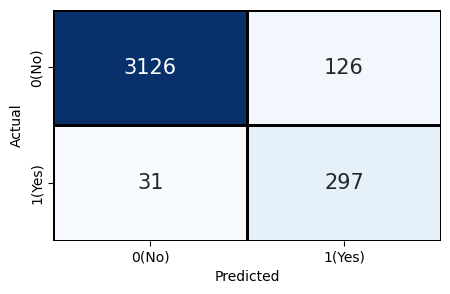

In [183]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize = (5, 3))
sns.heatmap(confusion_matrix(y_test4, y_test_pred), cmap = 'Blues',
            cbar = False, annot = True, annot_kws = {'size' : 15},
            fmt = '.0f', xticklabels = ['0(No)', '1(Yes)'], yticklabels = ['0(No)', '1(Yes)'],
            linecolor = 'k', linewidths = 0.8)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [262]:
base_metrics = {
    'Test Accuracy': 0.98,
    'Test Precision': 0.93,
    'Test Recall': 0.79,
    'Test F1': 0.85
}

xgb_test_metrics = {
    'Test Accuracy': round(xgb_model_final.score(x_test4, y_test4), 2),
    'Test Precision': round(precision_score(y_test4, y_test_pred), 2),
    'Test Recall': round(recall_score(y_test4, y_test_pred), 2),
    'Test F1': round(f1_score(y_test4, y_test_pred), 2)
}

base_df = pd.DataFrame([base_metrics])
xgb_test_df = pd.DataFrame([xgb_test_metrics])

base_df['Model'] = 'base'
xgb_test_df['Model'] = 'xgb_test'

base_df.set_index('Model', inplace=True)
xgb_test_df.set_index('Model', inplace=True)

xgb_result_df = pd.concat([base_df, xgb_test_df])

xgb_result_df

,Test Accuracy,Test Precision,Test Recall,Test F1
Model,,,,
base,0.98,0.93,0.79,0.85
xgb_test,0.96,0.71,0.90,0.80


## SVM start!!!
#### 참고자료
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [185]:
from sklearn.svm import SVC

In [194]:
# x_train1

svm_model = SVC(random_state=42)
get_metrics(model=svm_model, x_train=x_train1, y_train=y_train1)

훈련 정확도:  0.9795362480793407
훈련 recall:  0.8299008390541571
훈련 Precision:  0.9395509499136442
훈련 F1-score:  0.8813284730660186


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,0.404438,0.204538,0.981494,0.847909,0.944915,0.893788
1,0.379573,0.195475,0.977304,0.820611,0.922747,0.868687
2,0.383675,0.196222,0.978701,0.809160,0.950673,0.874227
3,0.374344,0.193501,0.977995,0.805344,0.946188,0.870103
4,0.379670,0.194503,0.977995,0.824427,0.927039,0.872727
mean,0.384340,0.196848,0.978698,0.821490,0.938312,0.875906


In [195]:
# x_train2

svm_model = SVC(random_state=42)
get_metrics(model=svm_model, x_train=x_train2, y_train=y_train2)

훈련 정확도:  0.8849003724037318
훈련 recall:  0.8506134969325153
훈련 Precision:  0.9135233075275901
훈련 F1-score:  0.8809467079660075


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,7.072067,3.450258,0.885029,0.868098,0.898769,0.883168
1,6.665959,3.194055,0.857006,0.786810,0.915663,0.846360
2,6.469014,3.179439,0.860626,0.795629,0.914903,0.851107
3,6.837163,3.369539,0.899981,0.883052,0.914252,0.898381
4,6.513832,3.206488,0.856786,0.788727,0.913410,0.846502
mean,6.711607,3.279956,0.871886,0.824463,0.911399,0.865104


In [196]:
# x_train3

svm_model = SVC(random_state=42)
get_metrics(model=svm_model, x_train=x_train3, y_train=y_train3)

훈련 정확도:  0.9790473529822601
훈련 recall:  0.8192219679633868
훈련 Precision:  0.9445910290237467
훈련 F1-score:  0.877450980392157


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,0.380075,0.203320,0.980796,0.832700,0.952174,0.888438
1,0.357702,0.193276,0.976606,0.812977,0.922078,0.864097
2,0.358018,0.193849,0.977304,0.793893,0.949772,0.864865
3,0.357141,0.196741,0.976249,0.778626,0.953271,0.857143
4,0.361639,0.196123,0.977646,0.820611,0.926724,0.870445
mean,0.362915,0.196662,0.977720,0.807761,0.940804,0.868998


In [197]:
# x_train4

svm_model = SVC(random_state=42)
get_metrics(model=svm_model, x_train=x_train4, y_train=y_train4)

훈련 정확도:  0.8775290820439974
훈련 recall:  0.8329754601226994
훈련 Precision:  0.9147717702543372
훈련 F1-score:  0.8719595408204224


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,7.717880,3.778352,0.890403,0.877684,0.900826,0.889105
1,7.020598,3.451303,0.850480,0.770706,0.917389,0.837675
2,6.806848,3.432065,0.851219,0.774156,0.915646,0.838978
3,7.421661,3.662397,0.887886,0.857362,0.913399,0.884494
4,7.221303,3.484910,0.851219,0.775307,0.914518,0.839178
mean,7.237658,3.561805,0.866241,0.811043,0.912356,0.857886


### x_train1 채택!!!(전체적으로 recall도 크게 차이 안나고 무난해보임)
#### 하이퍼 파라미터 조정!!!

In [207]:
svm_model = SVC(random_state=42,
                class_weight='balanced')

param_dist = {
    'C': uniform(1, 100),
    'kernel': ['linear', 'rbf'], # sigmoid는 성능이 안좋았음...
    'gamma': np.random.uniform(1, 100, size=5),
}

# 랜덤 서치 수행
random_search = RandomizedSearchCV(
    svm_model, param_distributions=param_dist, n_iter=20, cv=5, scoring='recall', random_state=42
)

# 학습 데이터에 랜덤 서치 수행
random_search.fit(x_train1, y_train1)

# 최적의 하이퍼파라미터와 평가 지표 출력
print("최적의 하이퍼파라미터: ", random_search.best_params_)
print("최고 recall: ", random_search.best_score_)

최적의 하이퍼파라미터:  {'C': 38.454011884736246, 'gamma': 11.932646184587496, 'kernel': 'linear'}
최고 recall:  0.9038806490000871


랜덤서치 1번<br>
최적의 하이퍼파라미터:  {'C': 3.0584494295802447, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}
최고 recall:  0.9107392679882738

- gamma를 auto 랑 scale만 썼는데 한번 직접 숫자로 기입해서 시작
랜덤서치 2번<br>
최적의 하이퍼파라미터:  {'C': 524.7574316322379, 'class_weight': 'balanced', 'gamma': 3.1123314993496725, 'kernel': 'linear'}
최고 recall:  0.9038806490000871

- class_weight의 경우 balanced를 설정하는게 다 나오므로 빼고 fit에 설정
랜덤서치 3번<br>
최적의 하이퍼파라미터:  {'C': 525.7564316322379, 'class_weight': 'balanced', 'gamma': 9.753524084905528, 'kernel': 'linear'}
최고 recall:  0.9038806490000871

랜덤서치 4번<br>
최적의 하이퍼파라미터:  {'C': 4.745401188473625, 'gamma': 1.753647357648114, 'kernel': 'linear'}
최고 recall:  0.903117290221461

랜덤서치 5번<br>
최적의 하이퍼파라미터:  {'C': 38.454011884736246, 'gamma': 11.932646184587496, 'kernel': 'linear'}
최고 recall:  0.9038806490000871

### GridSearch 시작!!!

In [216]:
svm_model = SVC(random_state=42,
                class_weight='balanced')

# 하이퍼파라미터 후보들을 딕셔너리 형태로 정의
param_grid = {
    'C': np.random.uniform(1, 1000, size=5),
    'kernel': ['poly'],
    'gamma': ['scale', 'auto'], # np.random.uniform(1, 100, size=5)
    'degree' : [2, 3, 4, 5]
}

# Recall을 사용하여 그리드 서치 수행
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='recall')

# 학습 데이터에 그리드 서치 수행
grid_search.fit(x_train1, y_train1)

# 최적의 파라미터와 성능 확인
print("최적의 하이퍼파라미터:", grid_search.best_params_)
print("최고 Recall:", grid_search.best_score_)

최적의 하이퍼파라미터: {'C': 601.6590243055539, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
최고 Recall: 0.9008301163904449


그리드서치 1번<br>
최적의 하이퍼파라미터: {'C': 24.67637920139087, 'gamma': 78.06155282858109, 'kernel': 'linear'}
최고 Recall: 0.9038806490000871

- gamma값 직접해보니 더 떨어지는 기분이라 다시 scale, auto로 변경
그리드서치 2번<br>
최적의 하이퍼파라미터: {'C': 32.819449744559364, 'gamma': 'scale', 'kernel': 'rbf'}
최고 Recall: 0.9076974428932167

- 계속 하이퍼파라미터는 바뀌는데 recall값이 너무 말도 안되게 똑같이 나오는 경우가 많다...
그리드서치 3번<br>
최적의 하이퍼파라미터: {'C': 191.74273161997786, 'gamma': 'scale', 'kernel': 'linear'}
최고 Recall: 0.9038806490000871

- 더 이상 성능 개선이 되지 않는것 같아 다항식 커널을 사용해보기로(poly)
그리드서치 4번<br>
최적의 하이퍼파라미터: {'C': 601.6590243055539, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
최고 Recall: 0.9008301163904449
- 시간에 비해 성능이 그닥... 그래도 테스트는 어떨지 잘 모르니 해보기

### 랜덤서치랑 그리드서치중 괜찮은거 몇개 테스트!!!

랜덤서치 1번<br>
최적의 하이퍼파라미터:  {'C': 3.0584494295802447, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}
최고 recall:  0.9107392679882738

In [219]:
svm_model_final = SVC(random_state=42,
                class_weight='balanced',
                C=3.0584494295802447,
                gamma='auto',
                kernel='rbf',
                )

In [218]:
get_metrics(model=svm_model_final, x_train=x_train1, y_train=y_train1)

훈련 정확도:  0.9748568235787121
훈련 recall:  0.9221967963386728
훈련 Precision:  0.8241308793456033
훈련 F1-score:  0.8704103671706264


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,1.202702,0.475776,0.978003,0.931559,0.844828,0.886076
1,1.027924,0.436474,0.969972,0.896947,0.799320,0.845324
2,1.082092,0.443005,0.972067,0.896947,0.815972,0.854545
3,1.114252,0.452060,0.976947,0.912214,0.847518,0.878676
4,1.054024,0.449009,0.973105,0.916031,0.813559,0.861759
mean,1.096199,0.451265,0.974019,0.910739,0.824239,0.865276


그리드서치 2번<br>
최적의 하이퍼파라미터: {'C': 32.819449744559364, 'gamma': 'scale', 'kernel': 'rbf'}
최고 Recall: 0.9076974428932167

In [220]:
svm_model_final = SVC(random_state=42,
                class_weight='balanced',
                C=32.819449744559364,
                gamma='scale',
                kernel='rbf',
                )

In [221]:
get_metrics(model=svm_model_final, x_train=x_train1, y_train=y_train1)

훈련 정확도:  0.9763235088699539
훈련 recall:  0.92372234935164
훈련 Precision:  0.8351724137931035
훈련 F1-score:  0.8772183991307497


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,1.458997,0.445336,0.974860,0.916350,0.828179,0.870036
1,1.267944,0.404984,0.972067,0.896947,0.815972,0.854545
2,1.306233,0.414326,0.972416,0.900763,0.816609,0.856624
3,1.345309,0.423401,0.976598,0.912214,0.844523,0.877064
4,1.271762,0.412452,0.970311,0.912214,0.794020,0.849023
mean,1.330049,0.420100,0.973250,0.907697,0.819861,0.861459


그리드서치 4번<br>
최적의 하이퍼파라미터: {'C': 601.6590243055539, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
최고 Recall: 0.9008301163904449

In [222]:
svm_model_final = SVC(random_state=42,
                class_weight='balanced',
                C=601.6590243055539,
                gamma='auto',
                kernel='poly',
                degree=3)

In [223]:
get_metrics(model=svm_model_final, x_train=x_train1, y_train=y_train1)

훈련 정확도:  0.9763235088699539
훈련 recall:  0.9191456903127384
훈련 Precision:  0.8379694019471489
훈련 F1-score:  0.8766824299745363


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,26.462101,0.143102,0.974860,0.912548,0.830450,0.869565
1,27.275526,0.130971,0.971718,0.885496,0.819788,0.851376
2,32.556572,0.133745,0.971718,0.889313,0.817544,0.851920
3,29.513940,0.135940,0.975201,0.900763,0.839858,0.869245
4,29.014335,0.133644,0.975201,0.916031,0.830450,0.871143
mean,28.964495,0.135480,0.973740,0.900830,0.827618,0.862650


### 최종은 역시 1번

In [227]:
svm_model_final = SVC(random_state=42,
                class_weight='balanced',
                C=32.819449744559364,
                gamma='scale',
                kernel='rbf',
                )

svm_model_final.fit(x_train1, y_train1)

SVC(C=32.819449744559364, class_weight='balanced', random_state=42)

In [228]:
y_test_pred = svm_model_final.predict(x_test1)
print("테스트 정확도: ", accuracy_score(y_test1, y_test_pred))
print("테스트 recall: ", recall_score(y_test1, y_test_pred))
print("테스트 Precision: ", precision_score(y_test1, y_test_pred))
print("테스트 F1-score: ", f1_score(y_test1, y_test_pred))

테스트 정확도:  0.9731843575418995
테스트 recall:  0.9085365853658537
테스트 Precision:  0.8186813186813187
테스트 F1-score:  0.8612716763005781


### SVM pikling

In [229]:
import pickle

# 모델 피클링 (저장)
with open('svm_model_final.pkl', 'wb') as file:
    pickle.dump(svm_model_final, file)

### matrix 확인

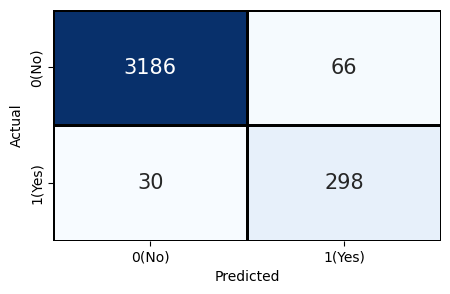

In [230]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize = (5, 3))
sns.heatmap(confusion_matrix(y_test1, y_test_pred), cmap = 'Blues',
            cbar = False, annot = True, annot_kws = {'size' : 15},
            fmt = '.0f', xticklabels = ['0(No)', '1(Yes)'], yticklabels = ['0(No)', '1(Yes)'],
            linecolor = 'k', linewidths = 0.8)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [263]:
base_metrics = {
    'Test Accuracy': 0.98,
    'Test Precision': 0.93,
    'Test Recall': 0.79,
    'Test F1': 0.85
}

svm_test_metrics = {
    'Test Accuracy': round(svm_model_final.score(x_test1, y_test1), 2),
    'Test Precision': round(precision_score(y_test1, y_test_pred), 2),
    'Test Recall': round(recall_score(y_test1, y_test_pred), 2),
    'Test F1': round(f1_score(y_test1, y_test_pred), 2)
}

base_df = pd.DataFrame([base_metrics])
svm_test_df = pd.DataFrame([svm_test_metrics])

base_df['Model'] = 'base'
svm_test_df['Model'] = 'svm_test'

base_df.set_index('Model', inplace=True)
svm_test_df.set_index('Model', inplace=True)

svm_result_df = pd.concat([base_df, svm_test_df])

svm_result_df

,Test Accuracy,Test Precision,Test Recall,Test F1
Model,,,,
base,0.98,0.93,0.79,0.85
svm_test,0.97,0.71,0.90,0.80


### 동기분과 얘기중에 오버샘플링만 해보지말고 언더샘플링도 해보자는 의견이 나옴
- x_train5를 생성해보기로 결정
- 타겟이 1:9 비율이기도 하고 1에 맞추게되면 데이터가 많이 줄어듬
- 성능도 더 떨어짐...

### 오버샘플링을 ADASYN만 사용해봤는데 SMOTE기법 얘기가 나와서 시도해보기로함 x_train5, 6생성

In [233]:
from imblearn.over_sampling import SMOTE

def split_dataset_smote(df, test_ratio = 0.2, select=1, upsampling=None):
    # 미리 전역변수로 설정해두기
    global x_df, y_df
    
    # 학습 데이터 분리
    x_df = df.drop('Class', axis=1)
    y_df = df['Class']
    
    x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=test_ratio, random_state=42, stratify=y_df)
    
    # 대표적인 표준화 두가지 중 택1
    if select == 1:
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()
    
    # 타겟이 불균형하므로 오버샘플링을 해보기(매개변수를 지정안해주면 None이 실행되므로 if문에 안들어감 2가지 방법 실험용)
    if upsampling:
        smote = SMOTE(random_state=42)
        x_train, y_train = smote.fit_resample(x_train, y_train)
    
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    x_train = pd.DataFrame(x_train, columns=x_df.columns)
    x_test = pd.DataFrame(x_test, columns=x_df.columns)

    return x_train, x_test, y_train, y_test

#### standard 사용 오버샘플링 사용 -> x_train5(안한거는 위에 사용 안한것들과 동일하기에 사용한것만)

In [234]:
x_train5, x_test5, y_train5, y_test5 = split_dataset_smote(df=bc_data, test_ratio=0.2, select=1, upsampling=1)

In [236]:
print('훈련 데이터 shape:', x_train5.shape, y_train5.shape)
print('테스트 데이터 shape:', x_test5.shape, y_test5.shape)

훈련 데이터 shape: (26014, 8) (26014,)
테스트 데이터 shape: (3580, 8) (3580,)


In [237]:
print(y_train5.value_counts(normalize=True))
y_test5.value_counts(normalize=True)

1    0.5
0    0.5
Name: Class, dtype: float64


0    0.90838
1    0.09162
Name: Class, dtype: float64

In [235]:
x_train6, x_test6, y_train6, y_test6 = split_dataset_smote(df=bc_data, test_ratio=0.2, select=2, upsampling=1)

In [238]:
print('훈련 데이터 shape:', x_train6.shape, y_train6.shape)
print('테스트 데이터 shape:', x_test6.shape, y_test6.shape)

훈련 데이터 shape: (26014, 8) (26014,)
테스트 데이터 shape: (3580, 8) (3580,)


In [239]:
print(y_train6.value_counts(normalize=True))
y_test6.value_counts(normalize=True)

1    0.5
0    0.5
Name: Class, dtype: float64


0    0.90838
1    0.09162
Name: Class, dtype: float64

#### logistic 모델(SMOTE)

- 성능이 조금 오름

In [240]:
lg_smote_model = LogisticRegression(random_state=42)

get_metrics(model=lg_smote_model, x_train=x_train5, y_train=y_train5)

훈련 정확도:  0.9421465364803567
훈련 recall:  0.9101253171369262
훈련 Precision:  0.972400197141449
훈련 F1-score:  0.9402327151423693


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,0.037259,0.005607,0.936767,0.902383,0.969047,0.934527
1,0.033109,0.005486,0.943302,0.908532,0.976456,0.941270
2,0.037850,0.005548,0.940996,0.907343,0.972795,0.938930
3,0.031893,0.005373,0.945993,0.917339,0.973083,0.944389
4,0.036641,0.005856,0.941176,0.910419,0.970094,0.939310
mean,0.035350,0.005574,0.941647,0.909203,0.972295,0.939685


In [241]:
lg_smote_model = LogisticRegression(random_state=42)

get_metrics(model=lg_smote_model, x_train=x_train6, y_train=y_train6)

훈련 정확도:  0.934765895287153
훈련 recall:  0.8972860767279157
훈련 Precision:  0.9699966755319149
훈련 F1-score:  0.9322257278645313


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,0.036838,0.005650,0.931386,0.894696,0.965574,0.928785
1,0.038541,0.005369,0.934653,0.897002,0.970075,0.932109
2,0.025618,0.005491,0.932539,0.893118,0.969533,0.929758
3,0.031987,0.005903,0.935806,0.898885,0.970527,0.933333
4,0.033466,0.005481,0.935602,0.899270,0.969735,0.933174
mean,0.033290,0.005579,0.933997,0.896594,0.969089,0.931432


In [251]:
y_test_pred = lg_smote_model.predict(x_test6)
print("테스트 정확도: ", accuracy_score(y_test6, y_test_pred))
print("테스트 recall: ", recall_score(y_test6, y_test_pred))
print("테스트 Precision: ", precision_score(y_test6, y_test_pred))
print("테스트 F1-score: ", f1_score(y_test6, y_test_pred))

테스트 정확도:  0.9667597765363128
테스트 recall:  0.9146341463414634
테스트 Precision:  0.7672634271099744
테스트 F1-score:  0.8344923504867873


### RandomForest

- ADASYN보다 떨어짐

In [242]:
rf_smote_model = RandomForestClassifier(random_state=42)

get_metrics(model=lg_smote_model, x_train=x_train5, y_train=y_train5)

훈련 정확도:  0.9421465364803567
훈련 recall:  0.9101253171369262
훈련 Precision:  0.972400197141449
훈련 F1-score:  0.9402327151423693


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,0.036056,0.005682,0.936767,0.902383,0.969047,0.934527
1,0.033490,0.005507,0.943302,0.908532,0.976456,0.941270
2,0.033282,0.005268,0.940996,0.907343,0.972795,0.938930
3,0.030680,0.005415,0.945993,0.917339,0.973083,0.944389
4,0.036183,0.005341,0.941176,0.910419,0.970094,0.939310
mean,0.033938,0.005443,0.941647,0.909203,0.972295,0.939685


In [243]:
rf_smote_model = RandomForestClassifier(random_state=42)

get_metrics(model=lg_smote_model, x_train=x_train6, y_train=y_train6)

훈련 정확도:  0.934765895287153
훈련 recall:  0.8972860767279157
훈련 Precision:  0.9699966755319149
훈련 F1-score:  0.9322257278645313


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,0.036289,0.005903,0.931386,0.894696,0.965574,0.928785
1,0.038240,0.005420,0.934653,0.897002,0.970075,0.932109
2,0.024544,0.005421,0.932539,0.893118,0.969533,0.929758
3,0.032968,0.005384,0.935806,0.898885,0.970527,0.933333
4,0.033981,0.005380,0.935602,0.899270,0.969735,0.933174
mean,0.033204,0.005502,0.933997,0.896594,0.969089,0.931432


### xgboost

- ???
- SMOTE oversampling을 적용한 데이터가 교차검증 성능이 너무 좋게나온다??

In [244]:
xgb_smote_model = XGBClassifier(random_state=42)

get_metrics(model=xgb_smote_model, x_train=x_train5, y_train=y_train5)

훈련 정확도:  0.9966172061197817
훈련 recall:  0.9976935496271239
훈련 Precision:  0.9955504411200614
훈련 F1-score:  0.9966208432532063


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,0.744151,0.009433,0.974438,0.968101,0.980537,0.974280
1,0.817583,0.008815,0.974822,0.975404,0.974280,0.974842
2,0.715238,0.009635,0.976936,0.979239,0.974742,0.976985
3,0.760986,0.008352,0.979435,0.979239,0.979615,0.979427
4,0.749674,0.008797,0.976740,0.978854,0.974732,0.976789
mean,0.757526,0.009007,0.976474,0.976167,0.976781,0.976464


In [245]:
xgb_smote_model = XGBClassifier(random_state=42)

get_metrics(model=xgb_smote_model, x_train=x_train6, y_train=y_train6)

훈련 정확도:  0.9966172061197817
훈련 recall:  0.9976935496271239
훈련 Precision:  0.9955504411200614
훈련 F1-score:  0.9966208432532063


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,0.754148,0.008993,0.974438,0.968101,0.980537,0.974280
1,0.776462,0.008915,0.974822,0.975404,0.974280,0.974842
2,0.776255,0.008506,0.976936,0.979239,0.974742,0.976985
3,0.724191,0.008446,0.979435,0.979239,0.979615,0.979427
4,0.780387,0.009743,0.976740,0.978854,0.974732,0.976789
mean,0.762289,0.008921,0.976474,0.976167,0.976781,0.976464


### SVM

- 처음부터 SMOTE를 썼어야 했던건가... ㅜㅜ

In [248]:
svm_smote_model = SVC(random_state=42)

get_metrics(model=svm_smote_model, x_train=x_train5, y_train=y_train5)

훈련 정확도:  0.9489890059198893
훈련 recall:  0.9199661720611978
훈련 Precision:  0.9766568723473719
훈련 F1-score:  0.9474642701611307


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,2.383724,1.543282,0.945224,0.912759,0.976161,0.943396
1,2.474886,1.562668,0.949068,0.920446,0.976355,0.947577
2,2.431266,1.551601,0.944647,0.911188,0.976514,0.942721
3,2.441433,1.553620,0.951759,0.926951,0.975324,0.950522
4,2.453950,1.561536,0.947905,0.917724,0.976678,0.946283
mean,2.437052,1.554541,0.947720,0.917814,0.976206,0.946100


In [249]:
svm_smote_model = SVC(random_state=42)

get_metrics(model=svm_smote_model, x_train=x_train6, y_train=y_train6)

훈련 정확도:  0.9480664257707389
훈련 recall:  0.9178134850465134
훈련 Precision:  0.9769230769230769
훈련 F1-score:  0.9464462678875807


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,2.423596,1.539381,0.944263,0.911222,0.975720,0.942369
1,2.436703,1.572672,0.947530,0.916987,0.976668,0.945887
2,2.410412,1.558851,0.943686,0.909650,0.976073,0.941692
3,2.467088,1.572669,0.950990,0.925029,0.975669,0.949674
4,2.452601,1.561414,0.948674,0.916955,0.979064,0.946992
mean,2.438080,1.560997,0.947029,0.915969,0.976639,0.945323


### 시간 관계로 ADASYN적용한 파일들로 전체 성능표

In [272]:
display(lg_result_df)
display(rf_result_df)
display(xgb_result_df)
display(svm_result_df)

,Test Accuracy,Test Precision,Test Recall,Test F1
Model,,,,
base,0.98,0.93,0.79,0.85
lg_test,0.97,0.78,0.92,0.85


,Test Accuracy,Test Precision,Test Recall,Test F1
Model,,,,
base,0.98,0.93,0.79,0.85
rf_test,0.96,0.71,0.90,0.80


,Test Accuracy,Test Precision,Test Recall,Test F1
Model,,,,
base,0.98,0.93,0.79,0.85
xgb_test,0.96,0.71,0.90,0.80


,Test Accuracy,Test Precision,Test Recall,Test F1
Model,,,,
base,0.98,0.93,0.79,0.85
svm_test,0.97,0.71,0.90,0.80
